# Clustering preprocessed data
In this notebook, we will be clustering the preprocessed data using different clustering algorithms and visualizing the results.

### Cell 1 - Imports

In [2]:
from src.utils import Utils

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering


### Cell 2 - Read data
Here i used my `Utils()` class to read the file but you can use any method you want.

In [3]:
utils = Utils()
data = utils.read_from_file(r'C:\Users\imran\DataspellProjects\WalidCase\data\processed\startup_dataset_clean_1560_range.csv', 'csv')
data

,Unnamed: 0,id,name,cb_description
0,0,1820,0xKYC,modular knowledge system identity credential m...
1,2,3640,10X-Genomics,create revolutionary dna sequence technology h...
2,3,9594,111Skin,commit positive luxury skincare push boundary ...
3,5,473,1stdibs,internet company offer marketplace rare desira...
4,6,7956,1v1Me,application allow user play match favorite vid...
...,...,...,...,...
2608,3992,2649,RoomLab,believe great interior design accessible avail...
2609,3995,6882,Rosaly,give ability manage advance payment request au...
2610,3996,4394,Roslin-Technologies,mission improve protein production disruptive ...
2611,3997,1036,Rossum,solve key step document base process receive d...


### Cell 3 - Testing Clustering Algorithms

This class is different than the `Clustering()` class in the `src/data/algorithms` folder. This one is a more barebones method used for testing different algorithms and visualizing the results. The `Clustering()` class is more of a pipeline that can be used to cluster data. This class takes in a dataframe and the number of topics and clusters you want to use. It then creates a TFIDF matrix and uses that matrix to cluster the data. It also uses the `TSNE` algorithm to visualize the clusters in 2D.

In [4]:
class TestingAlgos:

    def __init__(self, data, n_topics=123, n_clusters=10, cluster_dimensions=2):
        self.data = data
        self.n_clusters = n_clusters
        self.cluster_dimensions = cluster_dimensions
        self.tfidf = TfidfVectorizer(
            max_features=1000,
            strip_accents='unicode',
            analyzer='word',
            token_pattern=r'\w{1,}',
            stop_words='english',
            ngram_range=(1, 2),
            use_idf=True,
            smooth_idf=True,
            sublinear_tf=False
        )

        # # # # Topic Modelling Algos # # # #

        self.LDA = LatentDirichletAllocation(
            n_components=n_topics,
            learning_method='online',
            learning_offset=50,
            random_state=0
        )
        self.NMF = NMF(
            n_components=n_topics,
            init='nndsvd',
            random_state=0,
            max_iter=500
        )
        self.LSA = TruncatedSVD(
            n_components=n_topics,
            algorithm='arpack',
            random_state=0
        )

        self.TSNE = TSNE(
            n_components=self.cluster_dimensions,
            perplexity=50,
            learning_rate=200,
            random_state=0
        )

        # # # # Clustering Algos # # # #

        self.KM = KMeans(
            n_clusters=self.n_clusters,
            random_state=0
        )

        self.DBSCAN = DBSCAN(
            eps=0.5,
            min_samples=5
        )

        self.HC = AgglomerativeClustering(
            n_clusters=self.n_clusters,
            linkage='ward'
        )

    def Tfidf(self):
        self.about_us = self.data['cb_description'].tolist()
        return self.tfidf.fit_transform(self.about_us)

    def Lda(self):
        print('lda ran')
        matrix = self.Tfidf()
        topic_matrix = self.LDA.fit_transform(matrix)

    def add_top_words_to_df(self, topic_matrix, top_n=10):
        top_words = []
        feature_names = self.tfidf.get_feature_names_out()
        for topic_dist in topic_matrix:
            top_topic_words = [feature_names[i] for i in topic_dist.argsort()[:-top_n - 1:-1]]
            top_words.append(", ".join(top_topic_words))
        self.data['top_words'] = top_words
        return self.data

    def extract_top_words(self, topic_matrix, top_n=10):
        top_words = []
        feature_names = self.tfidf.get_feature_names_out()
        for topic_dist in topic_matrix:
            top_topic_words = [feature_names[i] for i in topic_dist.argsort()[:-top_n - 1:-1]]
            top_words.append(", ".join(top_topic_words))
        return top_words

    def visualize_clusters(self, algorithm='LDA', clustering='KM'):
        sparse_matrix = self.Tfidf()
        dense_matrix = sparse_matrix.toarray()
        model = algorithm
        if algorithm == 'LDA':
            model = self.LDA
        elif algorithm == 'NMF':
            model = self.NMF
        elif algorithm == 'LSA':
            model = self.LSA

        model.fit(dense_matrix)
        #dense_matrix = model.transform(dense_matrix)
        #cluster_labels = model.transform(dense_matrix).argmax(axis=1)

        # Visualize clusters
        self.tsne_output = self.TSNE.fit_transform(dense_matrix)

        if clustering == 'KM':
            cluster_labels = self.KM.fit_transform(self.tsne_output)
            cluster_labels = cluster_labels.argmax(axis=1)
        elif clustering == 'HC':
            cluster_labels = self.HC.fit_predict(self.tsne_output)
        elif clustering == 'DBSCAN':
            cluster_labels = self.DBSCAN.fit_predict(self.tsne_output)

        if clustering == 'DBSCAN':
            noise_points = cluster_labels == -1
            self.tsne_output = self.tsne_output[~noise_points]
            cluster_labels = cluster_labels[~noise_points]


        plt.figure(figsize=(8,6))
        plt.scatter(self.tsne_output[:, 0], self.tsne_output[:, 1], c= cluster_labels)
        plt.title(f'{algorithm} clustering with TFIDF and {clustering} (2D)')
        plt.show()


### Cell 4 - Testing different topic modelling and clustering algorithms

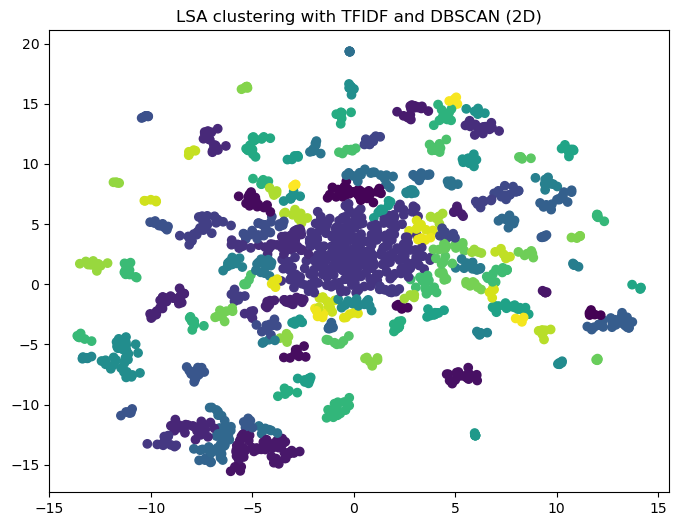

In [5]:
test_algos = TestingAlgos(data=data, n_topics=10, cluster_dimensions=2)

#test_algos.visualize_clusters(algorithm='LDA', clustering='KM')
#test_algos.visualize_clusters(algorithm='LSA', clustering='KM')
#test_algos.visualize_clusters(algorithm='NMF', clustering='KM')

#test_algos.visualize_clusters(algorithm='LDA', clustering='DBSCAN')
test_algos.visualize_clusters(algorithm='LSA', clustering='DBSCAN')
#test_algos.visualize_clusters(algorithm='NMF', clustering='DBSCAN')

#test_algos.visualize_clusters(algorithm='LDA', clustering='HC')
#test_algos.visualize_clusters(algorithm='LSA', clustering='HC')
#test_algos.visualize_clusters(algorithm='NMF', clustering='HC')


### Cell 5 - Extract top words from each topic

I This code extracts the top words following the topic modelling algorithms. I am using the top 10 words for each topic. I am also using the TFIDF vectorizer to vectorize the text beforehand. This method is buggy and is currently non-functional. It was working in the beginning, which is the result you see below the cell. I havent troubleshooted it yet and probably dont need to.

In [56]:
TestingAlgos.extract_top_words()

lda ran


[['day',
  'pioneer',
  'decision',
  'art',
  'spend',
  'care',
  'friend',
  'party',
  'state art',
  'asset'],
 ['pet',
  'parent',
  'care',
  'relationship',
  'tool',
  'client',
  'provide high',
  'modern',
  'producer',
  'long'],
 ['india',
  'country',
  'generation',
  'significant',
  'power',
  'south',
  'set',
  'group',
  'energy',
  'information'],
 ['datum',
  'antibody',
  'business',
  'service',
  'insight',
  'datum drive',
  'customer',
  'decision',
  'project',
  'increase'],
 ['inspire',
  'medium',
  'candidate',
  'love',
  'think',
  'social',
  'digital',
  'late',
  'lab',
  'online'],
 ['young',
  'workflow',
  'waste',
  'contract',
  'door',
  'dedicate',
  'engineering',
  'lifestyle',
  'view',
  'know'],
 ['tax',
  'exist',
  'pharmaceutical',
  'sale',
  'process',
  'business',
  'monitor',
  'manufacture',
  'investment',
  'banking'],
 ['line',
  'product',
  'identify',
  'computer',
  'help',
  'hire',
  'dna',
  'medical',
  'distribution'

## Word Embeddings

Text similarity can also be done using cosine similarity of word embeddings. Word embeddings are a way of representing words as vectors and BERT can generate these embeddings. The issue I see is that many of the industries are sort of similar. IOT is similar to AI and so on. So, I am not sure if this will work. But, I will try it out anyway.

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
from scipy.spatial.distance import cosine
from tqdm import tqdm

def bert_embeddings(texts, model, tokenizer, batch_size=10):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True)
        outputs = model(**inputs)
        print(outputs.last_hidden_state[:, 0, :])
        batch_embeddings = outputs.last_hidden_state[:, 0, :].squeeze().detach().cpu().numpy()
        embeddings.extend(batch_embeddings)
    return embeddings

def assign_industry(dataframe, industry_names):
    model = AutoModel.from_pretrained('bert-base-uncased')
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    startup_descriptions = dataframe['cb_description'].tolist()
    startup_embeddings = bert_embeddings(startup_descriptions, model, tokenizer)

    industry_embeddings = bert_embeddings(industry_names, model, tokenizer)

    assigned_industries = []
    for startup_embedding in startup_embeddings:
        startup_embedding = startup_embedding.reshape(-1)  # Ensure startup_embedding is 1-D
        similarities = [1 - cosine(startup_embedding, industry_embedding.reshape(-1)) for industry_embedding in industry_embeddings]  #
        best_industry_index = np.argmax(similarities)
        assigned_industries.append(industry_names[best_industry_index])

    dataframe['industry'] = assigned_industries
    return dataframe




In [14]:
with open(r'C:\Users\imran\DataspellProjects\WalidCase\data\raw\industry_dataset.csv', 'r', encoding='utf-8', errors='ignore') as f:
    industries = pd.read_csv(f)

industries = industries['name'].tolist()
industries = [industry.lower() for industry in industries]

['iot',
 'fashion',
 'travel',
 'cloud ops',
 'legaltech',
 'space tech',
 'telecoms',
 'familytech',
 'e-commerce',
 'sharing economy',
 'defense',
 'energy efficiency',
 'search',
 'edge computing',
 'web3',
 '3d printing',
 'electrification',
 'api-first',
 'ar/mr/vr',
 'transportation',
 'economic empowerment',
 'beauty',
 'health tech',
 'sport & wellness',
 'human resources',
 'communications',
 'business intelligence',
 'automation',
 'developer tools',
 'martech',
 'chemicals',
 'logistics',
 'design',
 'femtech',
 'robotics',
 'happiness & wellbeing',
 'death tech',
 'energy generation',
 'location services',
 'nutrition',
 'industrial iot',
 'adtech',
 'psychedelics',
 'nano',
 'connected life',
 'proptech',
 'data centers',
 'data infrastructure',
 'automotive',
 'crypto',
 'physical storage',
 'payments',
 'infosec',
 'analytics',
 'autonomous driving',
 'computer vision',
 'creator economy',
 'insurtech',
 'biodiversity',
 'energy storage',
 'deep tech',
 'regtech',
 'carb

In [36]:
startups = assign_industry(data[0:100], industries)

startups

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2/2 [00:03<00:00,  1.62s/it]
C:\Users\imran\AppData\Local\Temp\ipykernel_22548\3455252799.py:31: SettingWithCopyWarning: 
A value is tryin

,id,name,cb_description,industry
0,1820,0xKYC,modular knowledge system identity credential m...,cloud infrastructure
1,3640,10X-Genomics,genomic create revolutionary dna sequence tech...,genomics
2,9594,111Skin,commit positive luxury skincare push boundary ...,social impact
3,473,1stdibs,internet company offer marketplace rare desira...,developer tools
4,7956,1v1Me,application allow user play match favorite vid...,developer tools
...,...,...,...,...
95,1368,AIMLedge,aimledge develop software platform automate de...,cloud infrastructure
96,3573,AInnovation,ainnovation own operate company offer product ...,cloud infrastructure
97,1219,Ai-Palette,ai palette world artificial intelligence platf...,cloud infrastructure
98,10231,Airex,airex smart ventilation control build intellig...,cloud infrastructure
